In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
import catboost as catb
import lightgbm as lgb

from plot_mean_foehn_conditions import calculate_stability, plot_mean_foehn_condition_for_one_model, generate_coordinates_from_feature_label
from utils import calc_pot_temp

# Define constants

In [3]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Read ERA data

In [4]:
df_ERA_raw = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/ERAI_and_South_Foehn_Altdorf_data.csv.gz", parse_dates=["date"])

In [5]:
#df_ERA = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/ERAI_and_South_Foehn_Altdorf_data.csv.gz", parse_dates=["date"])
# df_ERA["date"] = pd.to_datetime(df_ERA["date"], format="%Y-%m-%dT%H:%M:00.000Z") # Only if reading from Dataiku file
df_ERA_raw.dropna(inplace=True)
df_ERA_raw.reset_index(inplace=True, drop=True)

In [6]:
df_ERA = df_ERA_raw.copy()

# Load CESM data 

In [7]:
df_CESMp = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [8]:
df_CESMf = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [9]:
# Calculate and append the stability parameters
df_CESMp = calculate_stability(df = df_CESMp, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)
df_CESMf = calculate_stability(df = df_CESMf, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

Pressure lvl doesnt exist (700-900 hPa, 4287, 0)
Pressure lvl doesnt exist (850-900 hPa, 4287, 0)
Pressure lvl doesnt exist (700-900 hPa, 4287, 125)
Pressure lvl doesnt exist (850-900 hPa, 4287, 125)
Pressure lvl doesnt exist (700-900 hPa, 4382, 250)
Pressure lvl doesnt exist (850-900 hPa, 4382, 250)
Pressure lvl doesnt exist (700-900 hPa, 4382, 375)
Pressure lvl doesnt exist (850-900 hPa, 4382, 375)
Pressure lvl doesnt exist (700-900 hPa, 4382, 500)
Pressure lvl doesnt exist (850-900 hPa, 4382, 500)
Pressure lvl doesnt exist (700-900 hPa, 4476, 250)
Pressure lvl doesnt exist (850-900 hPa, 4476, 250)
Pressure lvl doesnt exist (700-900 hPa, 4476, 375)
Pressure lvl doesnt exist (850-900 hPa, 4476, 375)
Pressure lvl doesnt exist (700-900 hPa, 4476, 500)
Pressure lvl doesnt exist (850-900 hPa, 4476, 500)
Pressure lvl doesnt exist (700-900 hPa, 4476, 625)
Pressure lvl doesnt exist (850-900 hPa, 4476, 625)
Pressure lvl doesnt exist (700-900 hPa, 4476, 750)
Pressure lvl doesnt exist (850-900 

# Use only features which are also in CESM and which are not in the Alps

In [10]:
# Only allow features which also exist in CESM
CESMp_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz", nrows=2).columns)
CESMf_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz", nrows=2).columns)
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
intersecting_features.append("Foehn")
df_ERA =df_ERA[intersecting_features]

In [11]:
# Cut Alps as an rectangle and drop those features
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [12]:
df_ERA

,T_4476_1000_500,V_4947_125_500,Z_4382_625_700,U_4759_250_700,U_4476_1500_500,Z_4664_250_700,U_4947_1250_500,Z_4382_1000_850,Z_4759_250_500,U_4853_1375_500,...,Z_4476_1375_500,T_4476_250_700,T_4476_1000_700,U_4664_375_850,Z_4853_1500_700,Z_4853_500_700,T_4853_625_900,T_4947_125_500,T_4287_500_700,Foehn
0,-21.747520,14.133276,2986.020264,3.638924,-3.434926,2979.247559,-12.421638,1425.943726,5553.433105,-13.231339,...,5543.894531,-6.277756,-4.500069,4.195312,2998.937256,2987.095703,8.717914,-20.555563,-4.194032,0.0
1,-22.001484,12.572963,3000.581055,2.705808,-2.868266,2990.343018,-12.475683,1439.953125,5562.482422,-12.770367,...,5554.898926,-5.855385,-4.683183,2.507849,3009.644043,2998.252441,7.471421,-20.023941,-4.505285,0.0
2,-22.028734,15.771315,3005.862549,3.070569,-0.044955,2991.256592,-12.552798,1448.626465,5557.326172,-12.615260,...,5560.372559,-6.672617,-5.350285,1.869440,3019.572266,3000.379883,5.581808,-20.097542,-4.993343,0.0
3,-21.439142,15.132396,3029.644287,3.495606,-2.740822,3015.679932,-9.876227,1472.102783,5577.007812,-9.327082,...,5596.691895,-6.188726,-3.981720,1.142172,3043.581543,3023.142578,7.050025,-20.893671,-4.379841,0.0
4,-21.219524,12.536766,3035.773193,2.215312,-1.276170,3022.200195,-7.792398,1475.474976,5584.480469,-7.929943,...,5610.942871,-5.202149,-3.555031,0.492317,3054.229004,3028.175537,8.497637,-20.877714,-3.463264,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54649,-21.934025,1.613145,3102.161377,10.688724,-5.126229,3064.490967,6.735518,1531.660034,5621.114258,4.674652,...,5678.824219,-5.175711,-1.908767,6.357795,3102.453125,3065.698242,10.016952,-21.982876,-3.844896,0.0
54650,-22.617165,-0.076083,3098.161377,5.863032,-3.006237,3066.763672,8.803169,1524.375488,5616.689941,5.721273,...,5667.877930,-5.092450,-2.149970,1.606971,3086.854736,3069.440674,9.784391,-21.690948,-4.222184,0.0
54651,-22.288477,-2.867782,3068.534424,-0.564148,-1.774944,3046.799316,10.606160,1496.163574,5588.763184,7.268699,...,5644.068848,-5.631272,-2.138574,-2.878623,3073.076904,3060.256592,8.038952,-23.325720,-3.888533,0.0
54652,-22.562243,0.087771,3067.668213,-5.887345,0.715060,3046.900391,9.060226,1494.914307,5591.666504,6.725373,...,5645.486328,-5.854045,-1.950980,-4.619369,3073.176025,3062.492676,8.636998,-23.609175,-3.825183,0.0


# Calculate derived variables

In [13]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

#df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)
df_pressures = pd.DataFrame(SLP_dict)

del SLP_dict

In [14]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

#df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)
df_Z = pd.DataFrame(Z_dict)

del df_Z_level, Z_dict

In [15]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T+273.15, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

#df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)
df_PHIT = pd.DataFrame(PHIT_dict)

del df_T, PHIT_dict

In [16]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T+273.15, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T+273.15, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T+273.15, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this lo

In [17]:
# Wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [18]:
df_ERA_all_features = pd.concat([df_ERA[["date", "Foehn"]], 
                                 df_pressures, 
                                 df_Z, 
                                 df_PHIT, 
                                 df_stability, 
                                 df_wind], 
                                axis = 1)

# Train Model on full data

In [19]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [20]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [21]:
def fit_clf_on_all_features(model, df_ERA, feature_names):
    
    # Fit model
    model.fit(df_ERA.loc[train_mask, feature_names], 
              df_ERA.loc[train_mask, "Foehn"])
    
    # Make predictions
    predictions = model.predict_proba(df_ERA.loc[test_mask, feature_names])
    
    # Calculate best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA.loc[test_mask, "Foehn"], predictions[:,1])
    best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
    predictions = (predictions[:,1]>best_threshold).astype(int)
    
    # Plot precision and recall curves
    f = plt.figure(figsize=(12,5))
    f.add_subplot(121)
    sns.lineplot(precisions, recalls)
    f.add_subplot(122)
    sns.lineplot(np.append(thresholds, 1.0), precisions)
    sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print best threshold, precision, recall and confusion matrix
    print(f"Best threshold: {best_threshold}")
    print(f'Precision: {precision_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(f'Recall: {recall_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(confusion_matrix(df_ERA.loc[test_mask, "Foehn"], predictions))
    
    # Show 50 most important features
    df_ERA_feature_importances = pd.DataFrame({"feature_name": feature_names, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
    display(df_ERA_feature_importances.head(50))
    
    return df_ERA_feature_importances

0:	learn: 0.6079418	total: 260ms	remaining: 4m 19s
1:	learn: 0.5420153	total: 487ms	remaining: 4m 3s
2:	learn: 0.4899908	total: 700ms	remaining: 3m 52s
3:	learn: 0.4505959	total: 917ms	remaining: 3m 48s
4:	learn: 0.4196578	total: 1.13s	remaining: 3m 45s
5:	learn: 0.3918547	total: 1.36s	remaining: 3m 44s
6:	learn: 0.3704521	total: 1.62s	remaining: 3m 49s
7:	learn: 0.3504767	total: 1.9s	remaining: 3m 55s
8:	learn: 0.3361671	total: 2.12s	remaining: 3m 53s
9:	learn: 0.3253162	total: 2.34s	remaining: 3m 51s
10:	learn: 0.3155074	total: 2.57s	remaining: 3m 51s
11:	learn: 0.3085164	total: 2.82s	remaining: 3m 51s
12:	learn: 0.3008058	total: 3.06s	remaining: 3m 52s
13:	learn: 0.2942755	total: 3.29s	remaining: 3m 51s
14:	learn: 0.2892317	total: 3.5s	remaining: 3m 50s
15:	learn: 0.2846454	total: 3.72s	remaining: 3m 48s
16:	learn: 0.2813247	total: 3.94s	remaining: 3m 48s
17:	learn: 0.2775580	total: 4.16s	remaining: 3m 47s
18:	learn: 0.2750983	total: 4.37s	remaining: 3m 45s
19:	learn: 0.2726073	tota

158:	learn: 0.1964205	total: 34.8s	remaining: 3m 4s
159:	learn: 0.1960589	total: 35s	remaining: 3m 3s
160:	learn: 0.1957764	total: 35.2s	remaining: 3m 3s
161:	learn: 0.1953992	total: 35.4s	remaining: 3m 3s
162:	learn: 0.1950985	total: 35.6s	remaining: 3m 2s
163:	learn: 0.1946910	total: 35.9s	remaining: 3m 2s
164:	learn: 0.1945683	total: 36s	remaining: 3m 2s
165:	learn: 0.1941360	total: 36.3s	remaining: 3m 2s
166:	learn: 0.1937899	total: 36.5s	remaining: 3m 1s
167:	learn: 0.1935202	total: 36.7s	remaining: 3m 1s
168:	learn: 0.1932494	total: 36.9s	remaining: 3m 1s
169:	learn: 0.1928751	total: 37.1s	remaining: 3m 1s
170:	learn: 0.1925492	total: 37.3s	remaining: 3m
171:	learn: 0.1923608	total: 37.5s	remaining: 3m
172:	learn: 0.1920585	total: 37.7s	remaining: 3m
173:	learn: 0.1917748	total: 38s	remaining: 3m
174:	learn: 0.1915044	total: 38.2s	remaining: 3m
175:	learn: 0.1912572	total: 38.4s	remaining: 2m 59s
176:	learn: 0.1910062	total: 38.6s	remaining: 2m 59s
177:	learn: 0.1907065	total: 38

314:	learn: 0.1616793	total: 1m 7s	remaining: 2m 27s
315:	learn: 0.1615561	total: 1m 7s	remaining: 2m 26s
316:	learn: 0.1613745	total: 1m 8s	remaining: 2m 26s
317:	learn: 0.1611439	total: 1m 8s	remaining: 2m 26s
318:	learn: 0.1609112	total: 1m 8s	remaining: 2m 26s
319:	learn: 0.1607441	total: 1m 8s	remaining: 2m 26s
320:	learn: 0.1605559	total: 1m 8s	remaining: 2m 25s
321:	learn: 0.1603670	total: 1m 9s	remaining: 2m 25s
322:	learn: 0.1601635	total: 1m 9s	remaining: 2m 25s
323:	learn: 0.1600166	total: 1m 9s	remaining: 2m 25s
324:	learn: 0.1599178	total: 1m 9s	remaining: 2m 24s
325:	learn: 0.1597783	total: 1m 9s	remaining: 2m 24s
326:	learn: 0.1596219	total: 1m 10s	remaining: 2m 24s
327:	learn: 0.1595529	total: 1m 10s	remaining: 2m 23s
328:	learn: 0.1593875	total: 1m 10s	remaining: 2m 23s
329:	learn: 0.1592072	total: 1m 10s	remaining: 2m 23s
330:	learn: 0.1590770	total: 1m 10s	remaining: 2m 23s
331:	learn: 0.1589467	total: 1m 11s	remaining: 2m 23s
332:	learn: 0.1587689	total: 1m 11s	rema

468:	learn: 0.1402805	total: 1m 38s	remaining: 1m 52s
469:	learn: 0.1401351	total: 1m 39s	remaining: 1m 51s
470:	learn: 0.1399975	total: 1m 39s	remaining: 1m 51s
471:	learn: 0.1398893	total: 1m 39s	remaining: 1m 51s
472:	learn: 0.1398080	total: 1m 39s	remaining: 1m 51s
473:	learn: 0.1396952	total: 1m 39s	remaining: 1m 50s
474:	learn: 0.1395547	total: 1m 40s	remaining: 1m 50s
475:	learn: 0.1393735	total: 1m 40s	remaining: 1m 50s
476:	learn: 0.1392913	total: 1m 40s	remaining: 1m 50s
477:	learn: 0.1392376	total: 1m 40s	remaining: 1m 50s
478:	learn: 0.1391417	total: 1m 40s	remaining: 1m 49s
479:	learn: 0.1390192	total: 1m 41s	remaining: 1m 49s
480:	learn: 0.1388876	total: 1m 41s	remaining: 1m 49s
481:	learn: 0.1388146	total: 1m 41s	remaining: 1m 49s
482:	learn: 0.1387695	total: 1m 41s	remaining: 1m 48s
483:	learn: 0.1387077	total: 1m 41s	remaining: 1m 48s
484:	learn: 0.1386392	total: 1m 42s	remaining: 1m 48s
485:	learn: 0.1385639	total: 1m 42s	remaining: 1m 48s
486:	learn: 0.1384945	total:

621:	learn: 0.1253157	total: 2m 9s	remaining: 1m 18s
622:	learn: 0.1252070	total: 2m 9s	remaining: 1m 18s
623:	learn: 0.1251564	total: 2m 10s	remaining: 1m 18s
624:	learn: 0.1250238	total: 2m 10s	remaining: 1m 18s
625:	learn: 0.1249717	total: 2m 10s	remaining: 1m 17s
626:	learn: 0.1248658	total: 2m 10s	remaining: 1m 17s
627:	learn: 0.1247900	total: 2m 10s	remaining: 1m 17s
628:	learn: 0.1246685	total: 2m 11s	remaining: 1m 17s
629:	learn: 0.1245494	total: 2m 11s	remaining: 1m 17s
630:	learn: 0.1244129	total: 2m 11s	remaining: 1m 16s
631:	learn: 0.1243665	total: 2m 11s	remaining: 1m 16s
632:	learn: 0.1242693	total: 2m 12s	remaining: 1m 16s
633:	learn: 0.1242227	total: 2m 12s	remaining: 1m 16s
634:	learn: 0.1240687	total: 2m 12s	remaining: 1m 16s
635:	learn: 0.1239470	total: 2m 12s	remaining: 1m 15s
636:	learn: 0.1238786	total: 2m 12s	remaining: 1m 15s
637:	learn: 0.1237603	total: 2m 13s	remaining: 1m 15s
638:	learn: 0.1236793	total: 2m 13s	remaining: 1m 15s
639:	learn: 0.1236008	total: 2

776:	learn: 0.1127797	total: 2m 41s	remaining: 46.2s
777:	learn: 0.1127419	total: 2m 41s	remaining: 46s
778:	learn: 0.1127109	total: 2m 41s	remaining: 45.8s
779:	learn: 0.1126642	total: 2m 41s	remaining: 45.6s
780:	learn: 0.1125129	total: 2m 41s	remaining: 45.4s
781:	learn: 0.1124834	total: 2m 42s	remaining: 45.2s
782:	learn: 0.1124244	total: 2m 42s	remaining: 45s
783:	learn: 0.1123612	total: 2m 42s	remaining: 44.8s
784:	learn: 0.1122705	total: 2m 42s	remaining: 44.6s
785:	learn: 0.1121774	total: 2m 42s	remaining: 44.3s
786:	learn: 0.1121052	total: 2m 43s	remaining: 44.1s
787:	learn: 0.1120267	total: 2m 43s	remaining: 43.9s
788:	learn: 0.1120029	total: 2m 43s	remaining: 43.7s
789:	learn: 0.1119679	total: 2m 43s	remaining: 43.5s
790:	learn: 0.1118967	total: 2m 43s	remaining: 43.3s
791:	learn: 0.1117978	total: 2m 44s	remaining: 43.1s
792:	learn: 0.1117668	total: 2m 44s	remaining: 42.9s
793:	learn: 0.1117367	total: 2m 44s	remaining: 42.7s
794:	learn: 0.1116264	total: 2m 44s	remaining: 42.

933:	learn: 0.1026469	total: 3m 12s	remaining: 13.6s
934:	learn: 0.1025454	total: 3m 12s	remaining: 13.4s
935:	learn: 0.1025201	total: 3m 12s	remaining: 13.2s
936:	learn: 0.1024443	total: 3m 13s	remaining: 13s
937:	learn: 0.1023451	total: 3m 13s	remaining: 12.8s
938:	learn: 0.1023116	total: 3m 13s	remaining: 12.6s
939:	learn: 0.1022727	total: 3m 13s	remaining: 12.4s
940:	learn: 0.1021638	total: 3m 14s	remaining: 12.2s
941:	learn: 0.1021266	total: 3m 14s	remaining: 12s
942:	learn: 0.1020922	total: 3m 14s	remaining: 11.8s
943:	learn: 0.1020372	total: 3m 14s	remaining: 11.5s
944:	learn: 0.1020029	total: 3m 14s	remaining: 11.3s
945:	learn: 0.1019780	total: 3m 15s	remaining: 11.1s
946:	learn: 0.1019531	total: 3m 15s	remaining: 10.9s
947:	learn: 0.1019126	total: 3m 15s	remaining: 10.7s
948:	learn: 0.1018354	total: 3m 15s	remaining: 10.5s
949:	learn: 0.1018132	total: 3m 15s	remaining: 10.3s
950:	learn: 0.1017703	total: 3m 15s	remaining: 10.1s
951:	learn: 0.1017490	total: 3m 16s	remaining: 9.8

,feature_name,importance
0,V_4759_1375_850,1.346816
1,diff_PHIT_4476_750_850_PHIT_4476_875_850,1.147805
2,DELTAPHI_4853_1000_700,1.035724
3,diff_SLP_4287_625_sealevel_SLP_4382_625_sealevel,1.029144
4,diff_Z_4476_1250_850_Z_4664_375_850,0.993806
5,diff_SLP_4287_500_sealevel_SLP_4382_500_sealevel,0.920276
6,diff_Z_4476_1000_850_Z_4853_875_850,0.895854
7,diff_Z_4476_1375_850_Z_4853_375_850,0.832643
8,diff_Z_4664_1375_850_Z_4664_250_850,0.823959
9,V_4476_875_850,0.806801


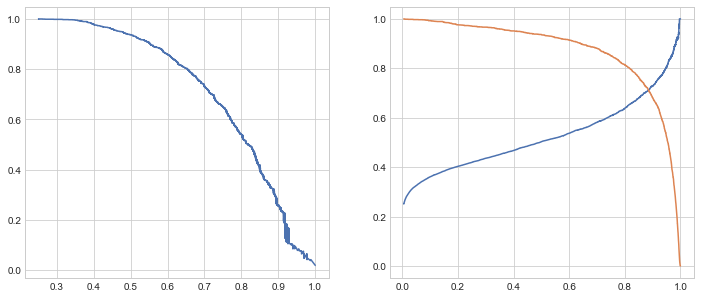

In [184]:
model_cat = catb.CatBoostClassifier(loss_function='Logloss',
                                verbose=True,
                                scale_pos_weight=20,
                                thread_count=20,
                                max_depth=4, 
                                learning_rate=0.1, 
                                n_estimators=1000,
                                reg_lambda=10,
                                   random_state=42)

df_ERA_feature_importances = fit_clf_on_all_features(model_cat, df_ERA_all_features, feature_names)

[16:57:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:57:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:57:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[16:57:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:57:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:58:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[16:58:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[16:58:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[16:58:10] INFO: /workspace/src/tree/upd

[17:01:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:01:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[17:01:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[17:01:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[17:01:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:01:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[17:01:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:01:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[17:01:38] INFO: /workspace/src/tree/upd

[17:04:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[17:04:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[17:04:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[17:04:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[17:04:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[17:04:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[17:04:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[17:05:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[17:05:06] INFO: /workspace/src/tree/upd

,feature_name,importance
0,diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,0.128121
1,diff_Z_4570_1375_850_Z_4664_375_850,0.110299
2,diff_SLP_4476_1375_sealevel_SLP_4853_750_sealevel,0.048021
3,diff_Z_4476_1500_850_Z_4476_500_850,0.043551
4,diff_SLP_4664_1375_sealevel_SLP_4853_1000_seal...,0.032169
5,diff_Z_4476_1500_850_Z_4476_625_850,0.024585
6,diff_PHIT_4476_875_850_PHIT_4853_1125_850,0.024020
7,diff_Z_4570_1375_850_Z_4570_375_850,0.022998
8,diff_Z_4476_1500_850_Z_4570_375_850,0.015772
9,diff_SLP_4382_1500_sealevel_SLP_4853_875_sealevel,0.014457


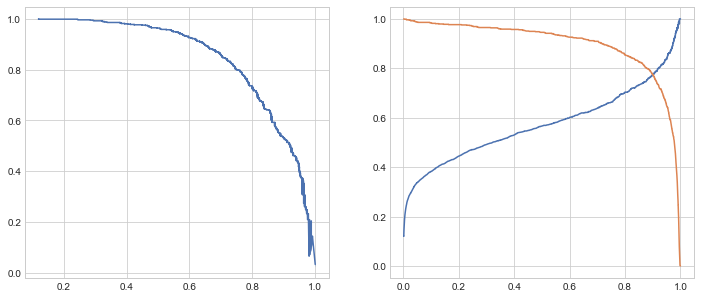

In [22]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=4,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=200,
                    verbosity=2,
                    nthread=20,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )
df_ERA_feature_importances = fit_clf_on_all_features(model_xg, df_ERA_all_features, feature_names)

# Reduce dataframe to most important features

In [23]:
df_ERA_reduced_features = df_ERA_all_features.loc[:,df_ERA_feature_importances.loc[:100, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [24]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), 
                                              columns = feature_names_reduced, 
                                              index=df_ERA_reduced_features.index)
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# Generate and preprocess CESM features

In [25]:
# Create features which are used by the simplified model
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

In [26]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Fit XGBoost to reduced feature set & evaluate

In [27]:
def plot_metrics_by_month(precision_scores, recall_scores, f1_scores):
    plt.figure(figsize=(16,9))
    plt.plot(MONTH_NAMES, precision_scores)
    plt.plot(MONTH_NAMES, recall_scores)
    plt.plot(MONTH_NAMES, f1_scores)
    plt.legend(["precision", "recall", "f1-score"])

In [28]:
def get_best_model_through_CV(model, parameters_CV):
    # Fit model
    model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
    model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], 
                 df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
    print(model_CV.best_params_)
    
    # Predict and optimize threshold
    best_model = model_CV.best_estimator_
    df_ERA_reduced_features_scaled.loc[:, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
    df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
    # Plot model evaluation curves
#     f = plt.figure(figsize=(12,5))
#     f.add_subplot(121)
#     sns.lineplot(precisions, recalls)
#     f.add_subplot(122)
#     sns.lineplot(np.append(thresholds, 1.0), precisions)
#     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print model evaluation scores
    
    df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]
    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]))
    display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
    precision_scores, recall_scores, f1_scores = [], [], []
    for month in range(1,12+1):
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)

    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
    return best_model, best_threshold_ERA

In [29]:
from sklearn.model_selection import cross_validate

def train_model_for_each_month(model, parameters):
    models_retrained_list, thresholds_list = [], []
    
    precision_scores, recall_scores, f1_scores = [], [], []
    
    plt.figure(figsize=(16,9))
    for month in range(1,12+1):
        # Define train and test masks
        train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        all_mask_month =  (df_ERA_reduced_features_scaled["date"].dt.month == month)
        
        # CV
#         model.set_params(scale_pos_weight=df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].count()/df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].sum())
#         print(model.get_params())
        model_CV = GridSearchCV(model, parameters, cv=[(slice(None), slice(None))], n_jobs=4, scoring=custom_metric_for_month, verbose=1)
        model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced], 
                     df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"])
        print(model_CV.cv_results_["mean_test_score"])
        # Get feature importance
#         print(dict(zip(feature_names_reduced, model_CV.best_estimator_.feature_importances_)))
        
        # Optimize threshold
        best_model = model_CV.best_estimator_
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced])[:,1]
        precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                                 df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
        best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
        # Print model evaluation scores
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)
        
        print(f"Best threshold: {best_threshold_ERA}")
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
        display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
        
        # Retrain model on full data
        best_model.fit(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced], 
                       df_ERA_reduced_features_scaled.loc[all_mask_month, "Foehn"])
        models_retrained_list.append(best_model)
        thresholds_list.append(best_threshold_ERA)
        
    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    return models_retrained_list, thresholds_list

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# from sklearn.metrics import log_loss, make_scorer
def custom_loss(predt: np.ndarray, dtrain: xgb.DMatrix, ERA_len, CESM_len, alpha=100000):
    y = dtrain.get_label()[:ERA_len]
    
    pred = sigmoid(predt)
    pred_ERA = pred[:ERA_len]
    pred_CESM = pred[ERA_len:]
    
    grad_logloss  = pred_ERA - y
    hess_logloss = pred_ERA*(1.0 - pred_ERA)

    
#     grad = () + 2*alpha/CESM_len*(np.mean(predt) - np.mean(y))
    
    grad_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y))
    hess_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*((1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y)) -
                                                            pred_CESM*(np.mean(pred_CESM)-np.mean(y)) +
                                                            pred_CESM*(1-pred_CESM)/CESM_len
                                                            )
    
    grad = np.zeros(len(predt))
    grad[:ERA_len] = grad_logloss
    grad[ERA_len:] = grad_custom
    
    hess = np.zeros(len(predt))
    hess[:ERA_len] = hess_logloss
    hess[ERA_len:] = hess_custom
    
    return grad, hess

def custom_metric_for_month(estimator, X, y):
    month_mask_ERA_custom_metric = (df_ERA_reduced_features_scaled["date"].dt.month == month)
    month_mask_CESMp_custom_metric = (df_CESMp_reduced_features_scaled["date"].dt.month == month)
    
    prediction_probas_ERA = estimator.predict_proba(X)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y, prediction_probas_ERA)
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]                                                         
    
    foehn_truth = df_ERA_reduced_features_scaled.loc[month_mask_ERA_custom_metric, "Foehn"]
    CESMp_predictions = (estimator.predict_proba(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp_custom_metric, feature_names_reduced]) >best_threshold_ERA).astype(int)
    
    
    
    
    return -np.square(np.mean(CESMp_predictions)-np.mean(foehn_truth))

In [101]:
monthly_models = 1

params = {'max_depth': 4, 'learning_rate': 0.1, "reg_alpha":10, "reg_lambda":10, "n_jobs": 30,"verbosity":1, "seed": 0}

models_retrained_list, thresholds_list = [], []
precision_scores, recall_scores, f1_scores= [], [], []

most_important_features = set()


# Train first on all data
D_train = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced],
                      label=df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
model_ges = xgb.Booster(params, [D_train])
model_ges = xgb.train(params, dtrain = D_train, num_boost_round=20, xgb_model=model_ges)
# for _ in range(50):
#     pred = model.predict(D_train)
#     g, h = custom_loss(pred, D_train, ERA_len=train_mask_month.sum(), CESM_len = month_mask_CESMp.sum())
#     model.boost(D_train, g, h)
print("Done Fitting on whole Dataset")

for month in range(1,12+1):
    train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
    month_mask_ERA = (df_ERA_reduced_features_scaled["date"].dt.month == month)
    test_mask_month = test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
    month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month)

    df_ERA_CESMp = pd.concat([df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced + ["Foehn"]], 
                              df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced]],
                            axis=0)
    print(len(df_ERA_CESMp))

    D_train = xgb.DMatrix(df_ERA_CESMp[feature_names_reduced],
                         label=df_ERA_CESMp["Foehn"])
#     model = xgb.Booster(params, [D_train])
    model = model_ges.copy()
    for _ in range(150):
        pred = model.predict(D_train)
        g, h = custom_loss(pred, D_train, ERA_len=train_mask_month.sum(), CESM_len = month_mask_CESMp.sum())
        model.boost(D_train, g, h)

    D_test = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[month_mask_ERA, feature_names_reduced])
    yhat = sigmoid(model.predict(D_test))
    
    
    df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction_proba"] = sigmoid(model.predict(D_test))
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
    thresholds_list.append(best_threshold_ERA)
    df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction"] = (df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction_proba"]>best_threshold_ERA).astype(int)

    # Print model evaluation scores
    precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1score)

    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))

    importances_month = pd.DataFrame.from_dict(model.get_score(importance_type='weight'), orient="index", columns=["importance"]).sort_values(by="importance", ascending=False)
    display(importances_month.head(10))
    
    most_important_features.update(set(importances_month.head(10).index))


    models_retrained_list.append(model)
    

Done Fitting on whole Dataset
46769
Best threshold: 0.3830210268497467
Precision: 0.6875
Recall: 0.676923076923077
[[1144   20]
 [  21   44]]


,importance
DELTAPHI_4853_1000_700,53
DELTAPHI_4853_875_700,50
DELTAPHI_4476_1000_700,36
V_4853_1125_850,32
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,32
diff_PHIT_4570_1375_850_PHIT_4853_1000_850,32
diff_Z_4382_750_700_Z_4476_1500_700,26
diff_Z_4476_1375_850_Z_4476_750_850,26
diff_SLP_4853_750_sealevel_SLP_4947_0_sealevel,26
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,25


42285
Best threshold: 0.2712681293487549
Precision: 0.8135593220338984
Recall: 0.8
[[1059   11]
 [  12   48]]


,importance
DELTAPHI_4853_875_700,51
diff_PHIT_4476_875_850_PHIT_4853_1000_850,38
DELTAPHI_4853_1000_700,33
diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,29
V_4664_1375_850,26
diff_PHIT_4570_1375_850_PHIT_4853_1000_850,25
diff_SLP_4476_1375_sealevel_SLP_4853_750_sealevel,25
diff_Z_4287_1000_850_Z_4476_625_850,25
diff_PHIT_4570_1375_850_PHIT_4759_1375_850,24
diff_SLP_4664_1375_sealevel_SLP_4853_875_sealevel,24


46820
Best threshold: 0.5179125070571899
Precision: 0.7192982456140351
Recall: 0.7068965517241379
[[1158   16]
 [  17   41]]


,importance
DELTAPHI_4853_875_700,74
DELTAPHI_4853_1000_700,59
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,36
diff_PHIT_4570_1375_850_PHIT_4853_1000_850,31
diff_Z_4476_625_850_Z_4476_875_850,29
V_4664_1375_850,26
diff_SLP_4853_875_sealevel_SLP_4947_500_sealevel,24
diff_PHIT_4382_750_850_PHIT_4853_1000_850,24
DELTAPHI_4853_1000_850,23
diff_Z_4853_1250_850_Z_4853_1500_850,20


45203
Best threshold: 0.599141538143158
Precision: 0.8467153284671532
Recall: 0.8405797101449275
[[1037   21]
 [  22  116]]


,importance
DELTAPHI_4853_875_700,72
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,55
DELTAPHI_4853_1000_700,45
diff_SLP_4476_875_sealevel_SLP_4853_875_sealevel,33
V_4476_750_850,33
diff_PHIT_4476_875_850_PHIT_4853_875_850,33
diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,33
diff_SLP_4664_1375_sealevel_SLP_4853_875_sealevel,33
diff_Z_4476_625_850_Z_4476_875_850,32
diff_PHIT_4476_1000_850_PHIT_4853_875_850,30


46797
Best threshold: 0.45857521891593933
Precision: 0.7064220183486238
Recall: 0.7
[[1092   32]
 [  33   77]]


,importance
DELTAPHI_4853_875_700,87
diff_Z_4382_750_700_Z_4476_1500_700,51
DELTAPHI_4853_1000_700,45
diff_PHIT_4570_1375_850_PHIT_4759_1375_850,45
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,40
V_4664_1375_850,33
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,32
diff_Z_4287_500_850_Z_4476_1125_850,27
diff_PHIT_4476_875_850_PHIT_4853_875_850,25
diff_Z_4476_625_850_Z_4476_875_850,25


45352
Best threshold: 0.32616275548934937
Precision: 0.6410256410256411
Recall: 0.625
[[1143   14]
 [  15   25]]


,importance
DELTAPHI_4853_875_700,50
diff_SLP_4853_875_sealevel_SLP_4947_500_sealevel,34
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,34
diff_SLP_4853_875_sealevel_SLP_4947_1000_sealevel,33
DELTAPHI_4853_1000_700,32
diff_PHIT_4476_875_850_PHIT_4853_1000_850,27
diff_Z_4476_625_850_Z_4476_875_850,26
diff_SLP_4476_875_sealevel_SLP_4853_875_sealevel,22
diff_PHIT_4570_1375_850_PHIT_4853_1000_850,22
diff_PHIT_4476_875_850_PHIT_4853_1125_850,20


46843
Best threshold: 0.4617155194282532
Precision: 0.6923076923076923
Recall: 0.6428571428571429
[[1208    4]
 [   5    9]]


,importance
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,51
DELTAPHI_4853_875_700,42
diff_Z_4476_1250_850_Z_4476_750_850,37
diff_SLP_4664_1375_sealevel_SLP_4853_1000_sealevel,32
diff_Z_4287_500_850_Z_4476_1125_850,31
DELTAPHI_4853_1000_700,28
diff_PHIT_4382_250_850_PHIT_4853_875_850,24
diff_Z_4476_625_850_Z_4476_875_850,22
diff_Z_4287_0_700_Z_4947_1500_700,20
diff_SLP_4664_1375_sealevel_SLP_4853_875_sealevel,20


46804
Best threshold: 0.2656734883785248
Precision: 0.6363636363636364
Recall: 0.6086956521739131
[[1208    8]
 [   9   14]]


,importance
DELTAPHI_4853_875_700,90
diff_Z_4853_875_850_Z_4947_1500_850,33
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,32
diff_Z_4287_500_850_Z_4476_1375_850,32
DELTAPHI_4853_1000_700,32
DELTAPHI_4476_1000_700,26
diff_PHIT_4382_250_850_PHIT_4853_750_850,26
diff_Z_4476_750_700_Z_4570_125_700,25
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,24
diff_Z_4476_750_850_Z_4476_875_850,21


45317
Best threshold: 0.34640607237815857
Precision: 0.7096774193548387
Recall: 0.6984126984126984
[[1117   18]
 [  19   44]]


,importance
DELTAPHI_4853_875_700,72
diff_PHIT_4570_1375_850_PHIT_4853_1000_850,50
diff_Z_4287_500_850_Z_4476_1375_850,39
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,39
DELTAPHI_4853_1000_700,39
diff_Z_4476_625_850_Z_4476_875_850,28
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,24
diff_PHIT_4476_875_850_PHIT_4853_1125_850,23
diff_PHIT_4570_1375_850_PHIT_4759_1375_850,22
V_4664_1375_850,21


46830
Best threshold: 0.5721929669380188
Precision: 0.782608695652174
Recall: 0.7714285714285715
[[1149   15]
 [  16   54]]


,importance
DELTAPHI_4853_1000_700,65
DELTAPHI_4853_875_700,42
diff_Z_4476_750_850_Z_4570_375_850,32
diff_PHIT_4570_1375_850_PHIT_4759_1375_850,26
diff_Z_4476_1375_850_Z_4476_750_850,26
diff_Z_4853_1375_700_Z_4853_750_700,25
DELTAPHI_4476_1000_700,24
diff_PHIT_4570_1375_850_PHIT_4853_1000_850,23
V_4664_1375_850,22
diff_Z_4476_500_850_Z_4476_875_850,19


45306
Best threshold: 0.7221519351005554
Precision: 0.7647058823529411
Recall: 0.7536231884057971
[[1104   16]
 [  17   52]]


,importance
DELTAPHI_4853_875_700,60
DELTAPHI_4853_1000_700,42
diff_Z_4476_1375_850_Z_4476_750_850,35
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,30
diff_SLP_4476_1000_sealevel_SLP_4853_750_sealevel,27
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,26
diff_Z_4476_625_850_Z_4476_875_850,25
diff_PHIT_4570_1375_850_PHIT_4759_1375_850,25
diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,24
DELTAPHI_4476_1000_700,21


46792
Best threshold: 0.37204235792160034
Precision: 0.7627118644067796
Recall: 0.75
[[1158   14]
 [  15   45]]


,importance
DELTAPHI_4853_875_700,42
DELTAPHI_4853_1000_700,34
V_4664_1375_850,31
diff_SLP_4476_875_sealevel_SLP_4853_875_sealevel,29
V_4853_1125_850,26
diff_Z_4476_500_850_Z_4476_875_850,26
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,22
diff_Z_4476_1375_850_Z_4476_750_850,21
diff_SLP_4759_1375_sealevel_SLP_4853_1250_sealevel,19
diff_Z_4570_1375_850_Z_4853_750_850,19


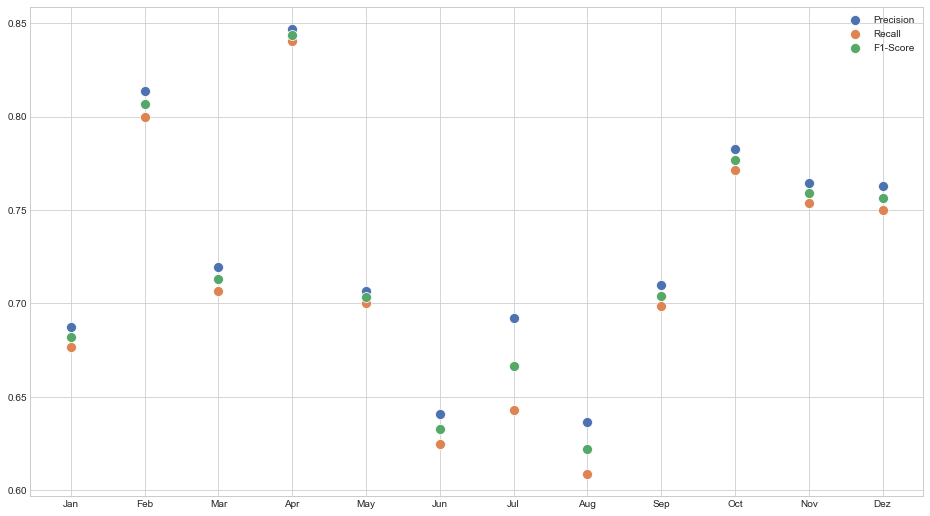

In [102]:
plt.figure(figsize=(16,9))
sns.scatterplot(MONTH_NAMES, precision_scores, s=100)
sns.scatterplot(MONTH_NAMES, recall_scores, s=100)
sns.scatterplot(MONTH_NAMES, f1_scores, s=100)
plt.legend(["Precision", "Recall", "F1-Score"])

# Predict on CESMp and CESMf

In [103]:
if monthly_models:
    for month in range(1,12+1):
        month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month )
        month_mask_CESMf = (df_CESMf_reduced_features_scaled["date"].dt.month == month )
        
        xgb_CESMp = xgb.DMatrix(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced])
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMp))
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction"] = (df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"]> thresholds_list[month-1]).astype(int)
        
        xgb_CESMf = xgb.DMatrix(df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, feature_names_reduced])
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMf))
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction"] = (df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"]> thresholds_list[month-1]).astype(int)
                                                 
df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Concenate all dataframes

In [104]:
# Create dataframe for actually observed foehn cases 
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn.rename({"Foehn": "prediction"}, axis=1, inplace=True)

In [105]:
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"

In [106]:
# Concat all observed foehn, ERAI, CESMp and CESMf prediction
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, 
                                      df_ERA_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]], 
                                      df_CESMp_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]], 
                                      df_CESMf_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]]], 
                                     axis=0, 
                                     ignore_index=True)

In [107]:
# Might be necessary to transform type of date column (should not)
# df_foehn_ERA_CESMp_CESMf["date"] = pd.to_datetime(df_foehn_ERA_CESMp_CESMf["date"], utc=True)

In [108]:
# Create month and year column
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [109]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [110]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1990< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

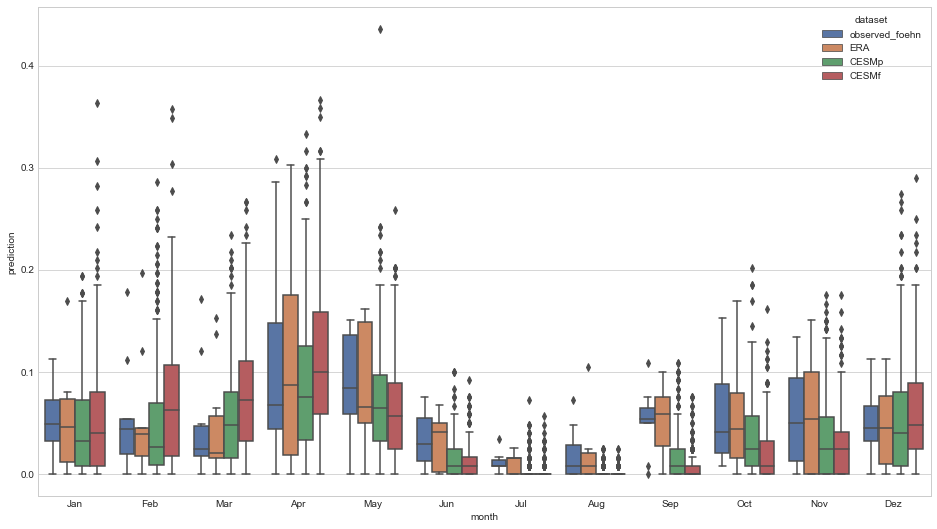

In [111]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(16,9))
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])
fig.set_xticklabels(MONTH_NAMES);

# Second statistical test

(0.0, 0.5)

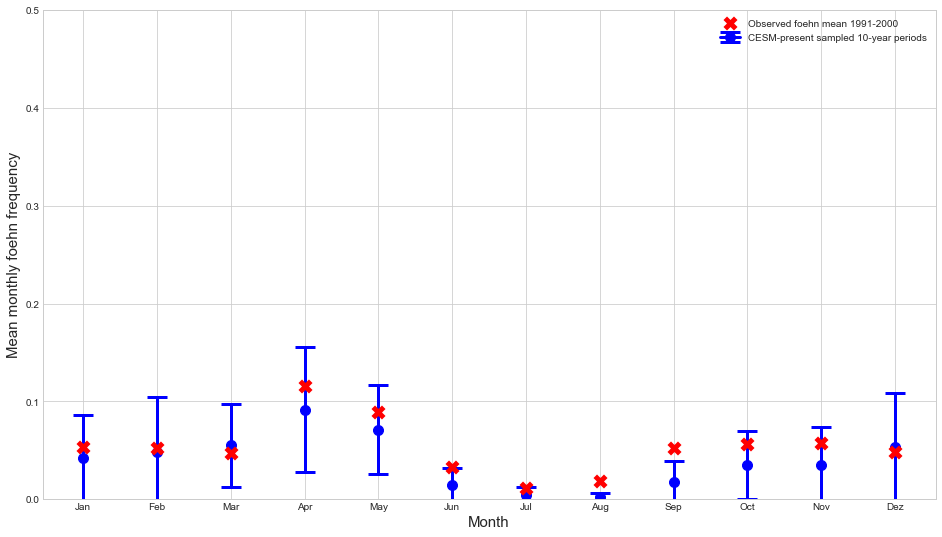

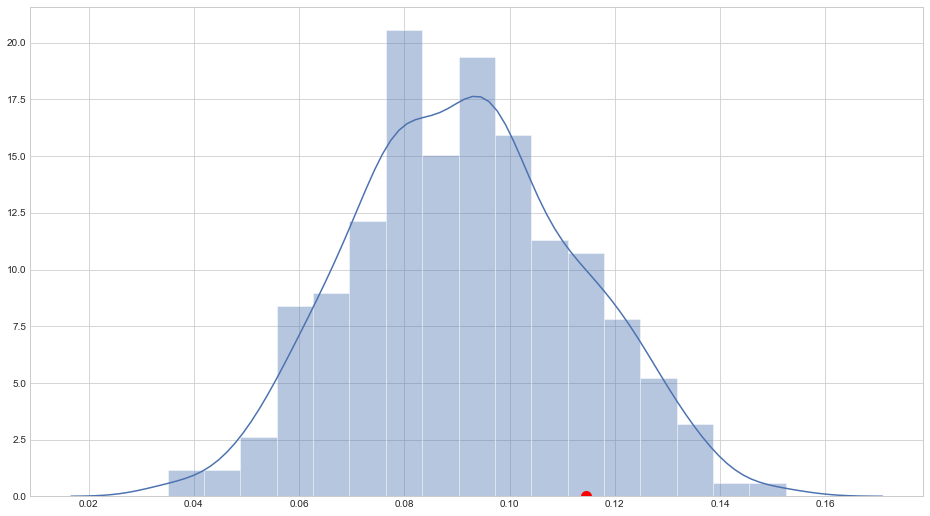

In [112]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(500):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 3*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="observed_foehn") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["Observed foehn mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month",fontsize=15)
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.50))


# Third statistical test

In [113]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.01))

Jan	0.07352	False
Feb	0.0	True
Mar	1e-05	True
Apr	0.0101	False
May	0.03996	False
Jun	0.33414	False
Jul	0.10725	False
Aug	0.68163	False
Sep	0.0	True
Oct	0.0	True
Nov	0.33414	False
Dez	0.10725	False


# Ensemble deviation

Text(0, 0.5, 'Mean monthly foehn prediction')

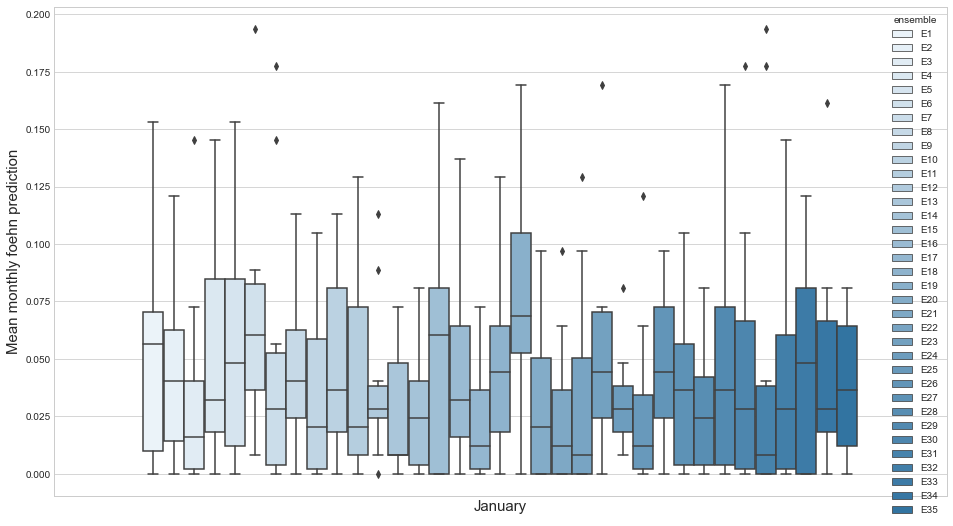

In [114]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January",fontsize=15)
ax.set_ylabel("Mean monthly foehn prediction",fontsize=15)
# sns.set(font_scale=0.8)

# Plot weathermaps

In [78]:
df_ERA_raw_temp_adjusted = df_ERA_raw.copy()

temp_columns = df_ERA_raw_temp_adjusted.filter(regex="T_").columns
df_ERA_raw_temp_adjusted[temp_columns] = df_ERA_raw_temp_adjusted[temp_columns]+ 273.15
df_ERA_with_stability = calculate_stability(df = df_ERA_raw_temp_adjusted, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)


In [79]:
variable = 'SLP'

variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700",
                "V": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "$^\circ$C",
        "DELTAPHI": "$^\circ$C",
        "U": "m/s",
        "V": "m/s"}


# Altdorf
v_limits = {"SLP": [1003, 1018],
            "Z": [1350, 1520],
            "T": [17+273.15, 21+273.15],
            "DELTAPHI": [6,11],
            "U":[5,15],
            "V":[5,15]}

# Piotta
# v_limits = {"SLP": [1013, 1025],#[1003, 1018],
#             "Z": [1460, 1530],#[1350, 1520],
#             "T": [-1+273.15, 6+273.15],
#             "DELTAPHI": [5.5, 12.5], #[6,11],
#             "U":[5,15],
#             "V":[5,15]}

df_importances = generate_coordinates_from_feature_label(most_important_features, variable)

Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_SLP_sealevel_OBS_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_SLP_sealevel_ERA_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_SLP_sealevel_CESMp_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_SLP_sealevel_CESMf_SouthFoehn.pdf'


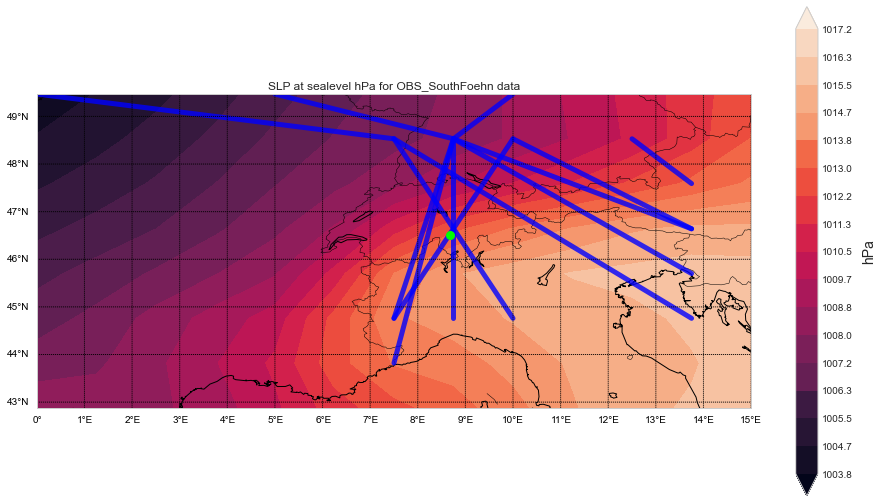

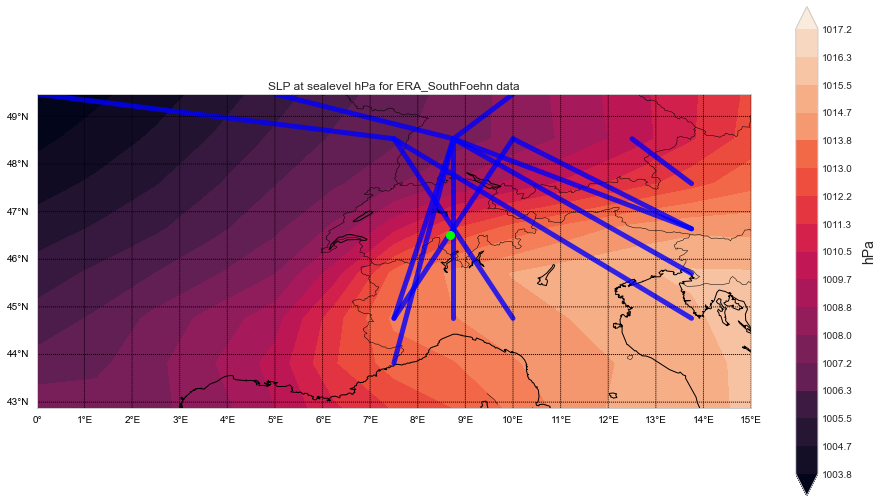

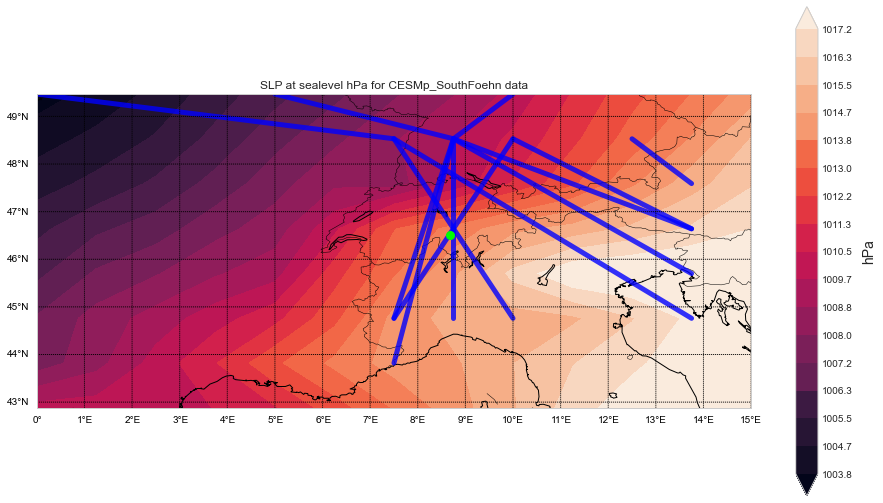

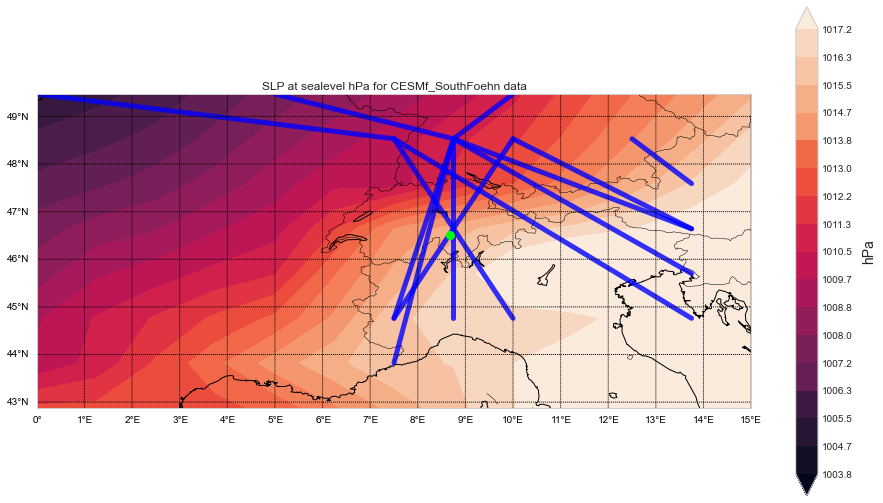

In [80]:
kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING, 
          "df_importances": df_importances}


month = 4
month_mask_ERA = df_ERA_with_stability["date"].dt.month == month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= "OBS_SouthFoehn", 
                                        df = df_ERA_with_stability.loc[:,:], 
                                        foehn = df_ERA_with_stability.loc[:, "Foehn"], 
                                        )

plot_mean_foehn_condition_for_one_model(**kwargs,
                                        model= "ERA_SouthFoehn",
                                        df = df_ERA_with_stability.loc[:,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[:, "prediction"], 
                                        )

month_mask_CESMp = df_CESMp["date"].dt.month== month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= "CESMp_SouthFoehn", 
                                        df = df_CESMp.loc[:,:], 
                                        foehn = df_CESMp_reduced_features_scaled.loc[:, "prediction"], 
                                        )
month_mask_CESMf = df_CESMf["date"].dt.month== month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= "CESMf_SouthFoehn",
                                        df = df_CESMf.loc[:,:], 
                                        foehn = df_CESMf_reduced_features_scaled.loc[:, "prediction"], 
                                        )

In [59]:
most_important_features

{'DELTAPHI_4476_1000_700',
 'DELTAPHI_4853_1000_700',
 'DELTAPHI_4853_1000_850',
 'DELTAPHI_4853_875_700',
 'V_4476_750_850',
 'V_4664_1375_850',
 'V_4853_1125_850',
 'diff_PHIT_4287_0_850_PHIT_4853_750_850',
 'diff_PHIT_4287_0_850_PHIT_4853_875_850',
 'diff_PHIT_4382_250_850_PHIT_4853_750_850',
 'diff_PHIT_4382_250_850_PHIT_4853_875_850',
 'diff_PHIT_4382_750_850_PHIT_4853_1000_850',
 'diff_PHIT_4476_1000_850_PHIT_4853_1125_850',
 'diff_PHIT_4476_875_850_PHIT_4759_1375_850',
 'diff_PHIT_4476_875_850_PHIT_4853_1000_850',
 'diff_PHIT_4476_875_850_PHIT_4853_1125_850',
 'diff_PHIT_4476_875_850_PHIT_4853_875_850',
 'diff_PHIT_4570_1375_850_PHIT_4759_1375_850',
 'diff_PHIT_4570_1375_850_PHIT_4853_1000_850',
 'diff_PHIT_4853_1000_850_PHIT_4947_1000_850',
 'diff_SLP_4382_750_sealevel_SLP_4853_875_sealevel',
 'diff_SLP_4476_1000_sealevel_SLP_4853_750_sealevel',
 'diff_SLP_4476_1375_sealevel_SLP_4853_750_sealevel',
 'diff_SLP_4476_750_sealevel_SLP_4853_1000_sealevel',
 'diff_SLP_4476_750_sealev